In [1]:
import json
import os
import matplotlib.pyplot as plt

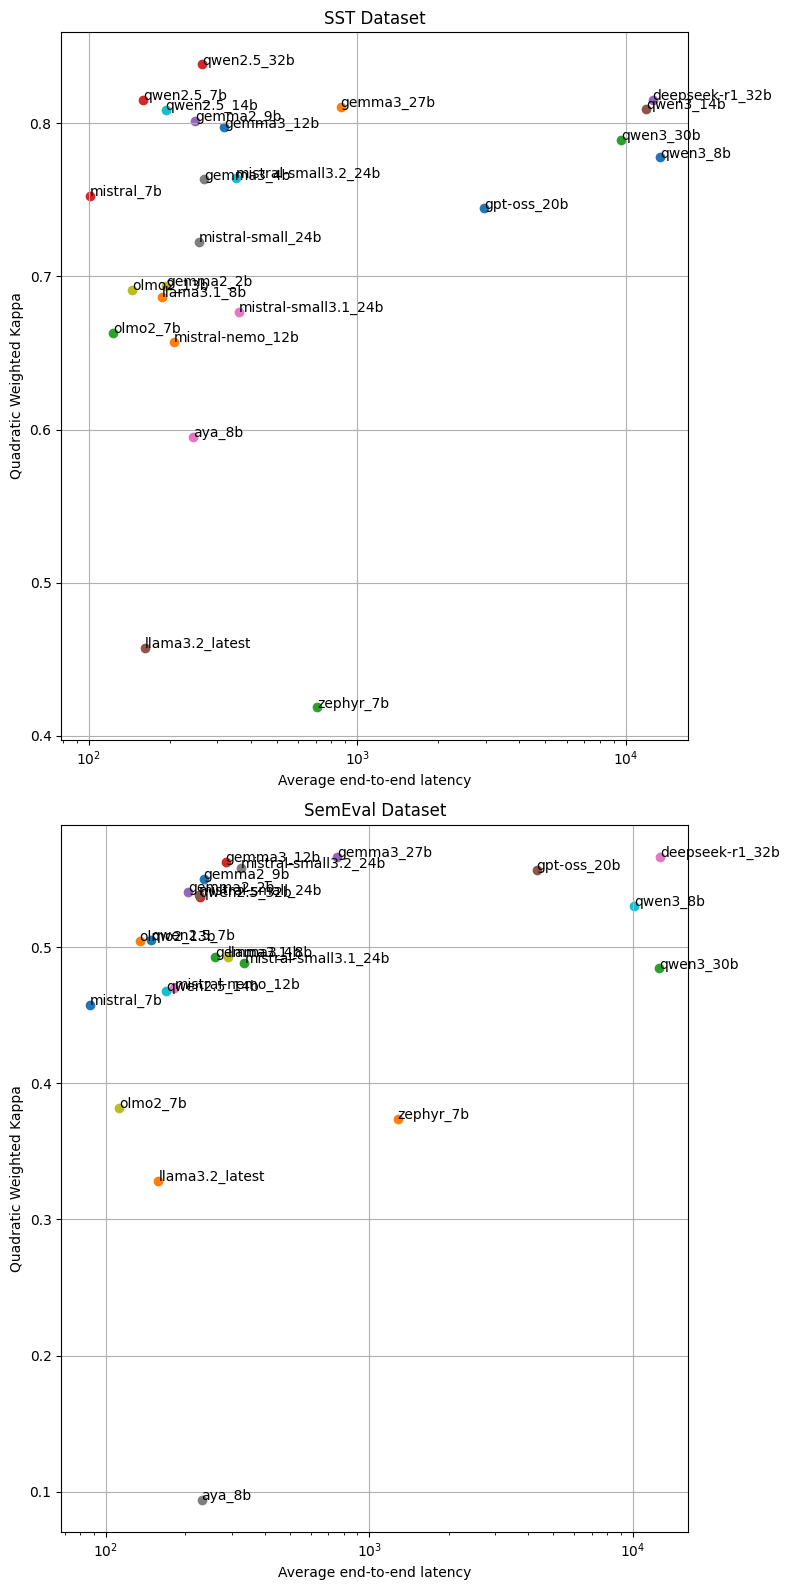

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Average end-to-end latency")
axes[0].set_ylabel("Quadratic Weighted Kappa")
axes[0].set_title("SST Dataset")
axes[0].set_xscale('log')

axes[1].set_xlabel("Average end-to-end latency")
axes[1].set_ylabel("Quadratic Weighted Kappa")
axes[1].set_title("SemEval Dataset")
axes[1].set_xscale('log')

for file in os.listdir():
	if file[-4:] != 'json':
		continue
	if file[:3] == "phi":
		continue
	with open(file, "r") as f:
		performance = json.load(f)
		model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
		if file[-8:] == "sst.json":
			axes[0].scatter(performance["Average end-to-end latency"],
							performance["Quadratic Weighted Kappa"])
			axes[0].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Quadratic Weighted Kappa"]))
		else:  # semeval
			axes[1].scatter(performance["Average end-to-end latency"],
							performance["Quadratic Weighted Kappa"])
			axes[1].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Quadratic Weighted Kappa"]))

plt.tight_layout()
for ax in axes:
	ax.grid(True)
plt.show()

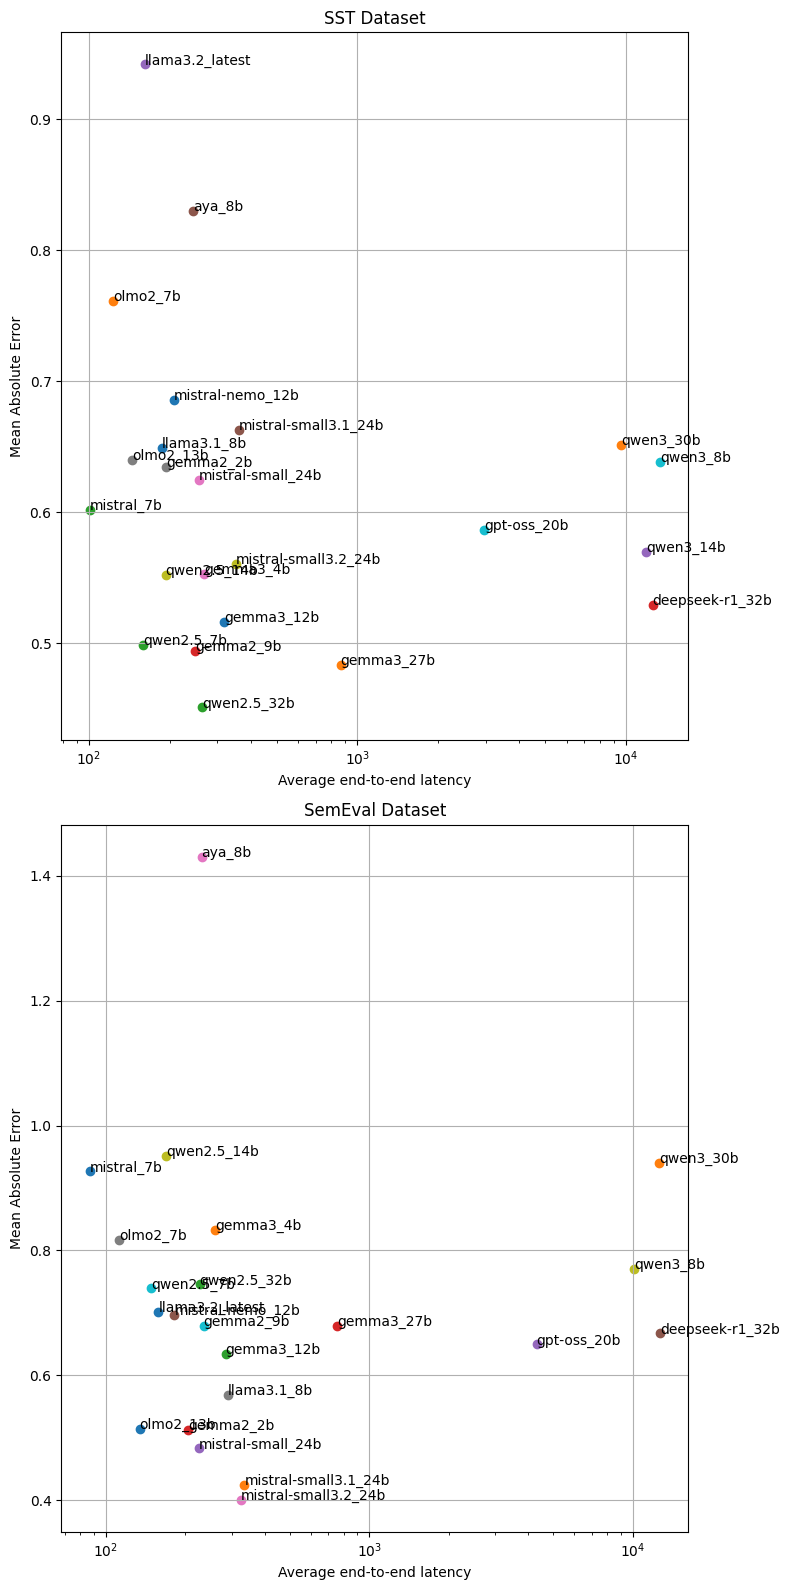

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Average end-to-end latency")
axes[0].set_ylabel("Mean Absolute Error")
axes[0].set_title("SST Dataset")
axes[0].set_xscale('log')

axes[1].set_xlabel("Average end-to-end latency")
axes[1].set_ylabel("Mean Absolute Error")
axes[1].set_title("SemEval Dataset")
axes[1].set_xscale('log')

for file in os.listdir():
	if file[-4:] != 'json':
		continue
	if file[:3] == "phi" or file[:3] == "zep":
		continue
	with open(file, "r") as f:
		performance = json.load(f)
		model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
		if file[-8:] == "sst.json":
			axes[0].scatter(performance["Average end-to-end latency"],
							performance["Mean Absolute Error"])
			axes[0].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Mean Absolute Error"]))
		else:  # semeval
			axes[1].scatter(performance["Average end-to-end latency"],
							performance["Mean Absolute Error"])
			axes[1].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Mean Absolute Error"]))

plt.tight_layout()
for ax in axes:
	ax.grid(True)
plt.show()

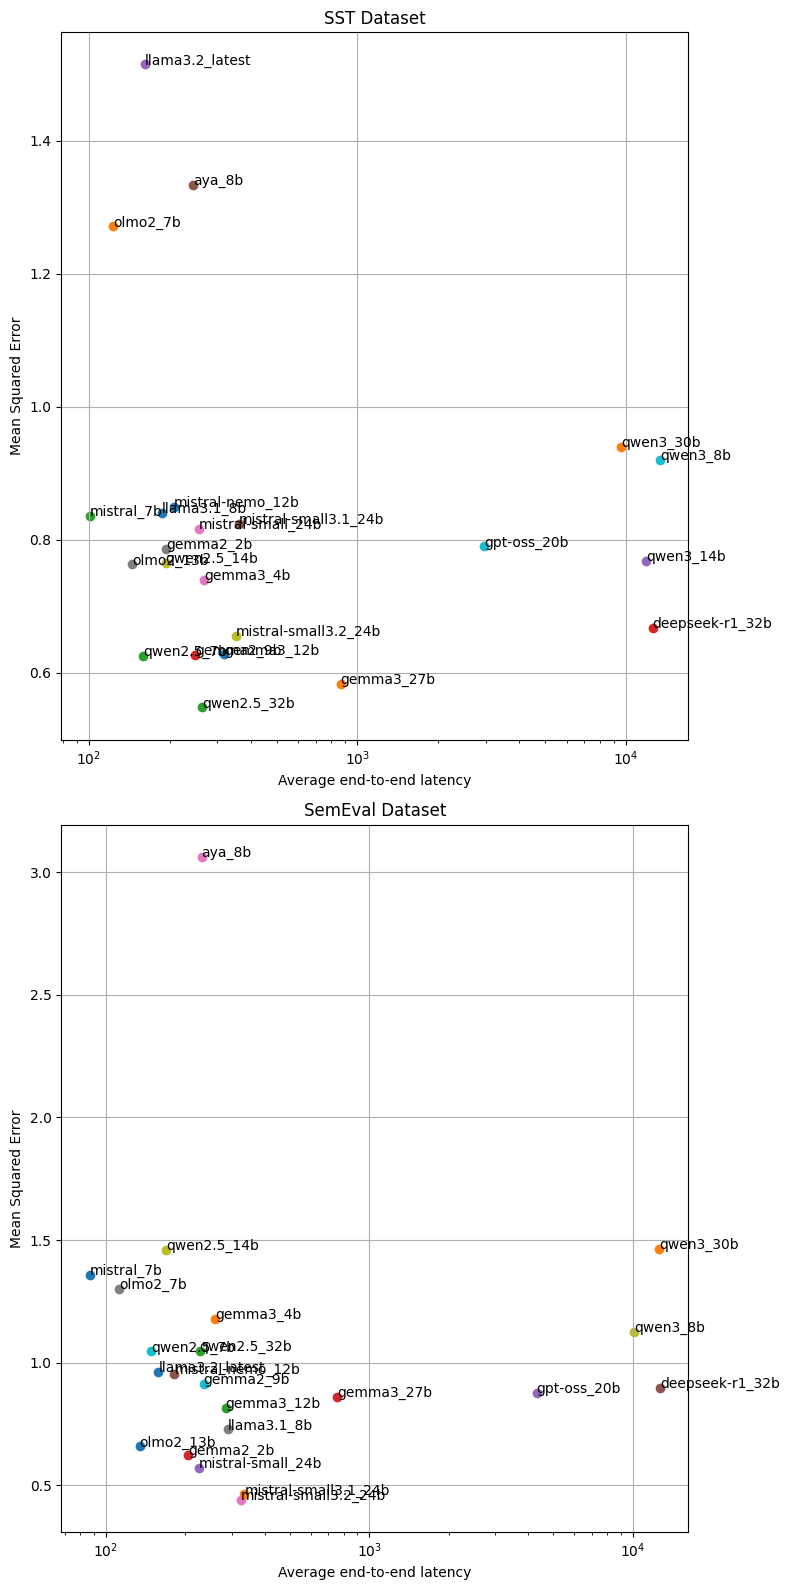

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Average end-to-end latency")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_title("SST Dataset")
axes[0].set_xscale('log')

axes[1].set_xlabel("Average end-to-end latency")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_title("SemEval Dataset")
axes[1].set_xscale('log')

for file in os.listdir():
	if file[-4:] != 'json':
		continue
	if file[:3] == "phi" or file[:3] == "zep":
		continue
	with open(file, "r") as f:
		performance = json.load(f)
		model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
		if file[-8:] == "sst.json":
			axes[0].scatter(performance["Average end-to-end latency"],
							performance["Mean Squared Error"])
			axes[0].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Mean Squared Error"]))
		else:  # semeval
			axes[1].scatter(performance["Average end-to-end latency"],
							performance["Mean Squared Error"])
			axes[1].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Mean Squared Error"]))

plt.tight_layout()
for ax in axes:
	ax.grid(True)
plt.show()

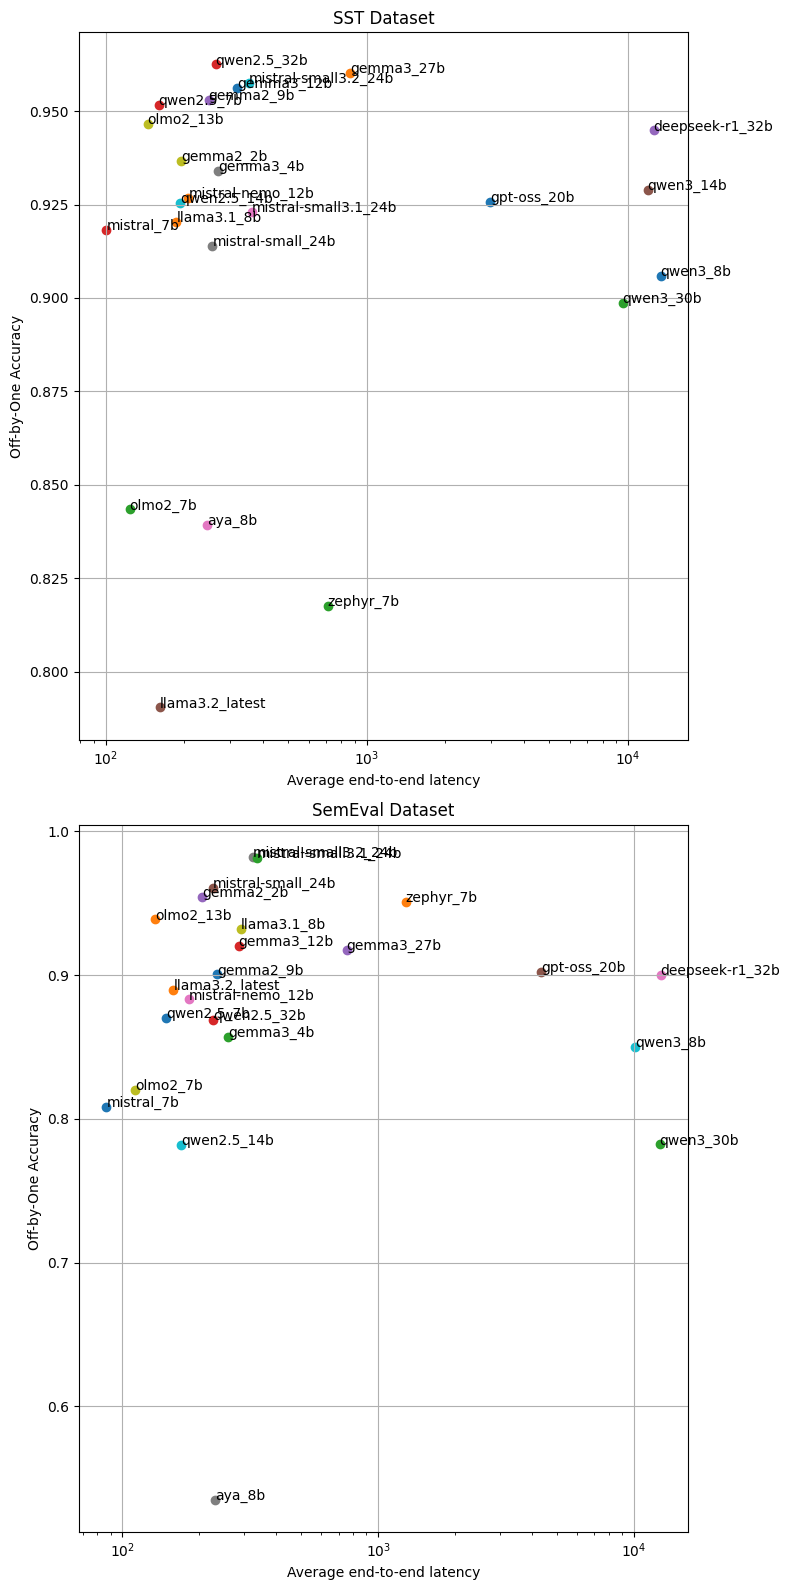

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Average end-to-end latency")
axes[0].set_ylabel("Off-by-One Accuracy")
axes[0].set_title("SST Dataset")
axes[0].set_xscale('log')

axes[1].set_xlabel("Average end-to-end latency")
axes[1].set_ylabel("Off-by-One Accuracy")
axes[1].set_title("SemEval Dataset")
axes[1].set_xscale('log')

for file in os.listdir():
	if file[-4:] != 'json':
		continue
	if file[:3] == "phi":
		continue
	with open(file, "r") as f:
		performance = json.load(f)
		model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
		if file[-8:] == "sst.json":
			axes[0].scatter(performance["Average end-to-end latency"],
							performance["Off-by-One Accuracy"])
			axes[0].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Off-by-One Accuracy"]))
		else:  # semeval
			axes[1].scatter(performance["Average end-to-end latency"],
							performance["Off-by-One Accuracy"])
			axes[1].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Off-by-One Accuracy"]))

plt.tight_layout()
for ax in axes:
	ax.grid(True)
plt.show()

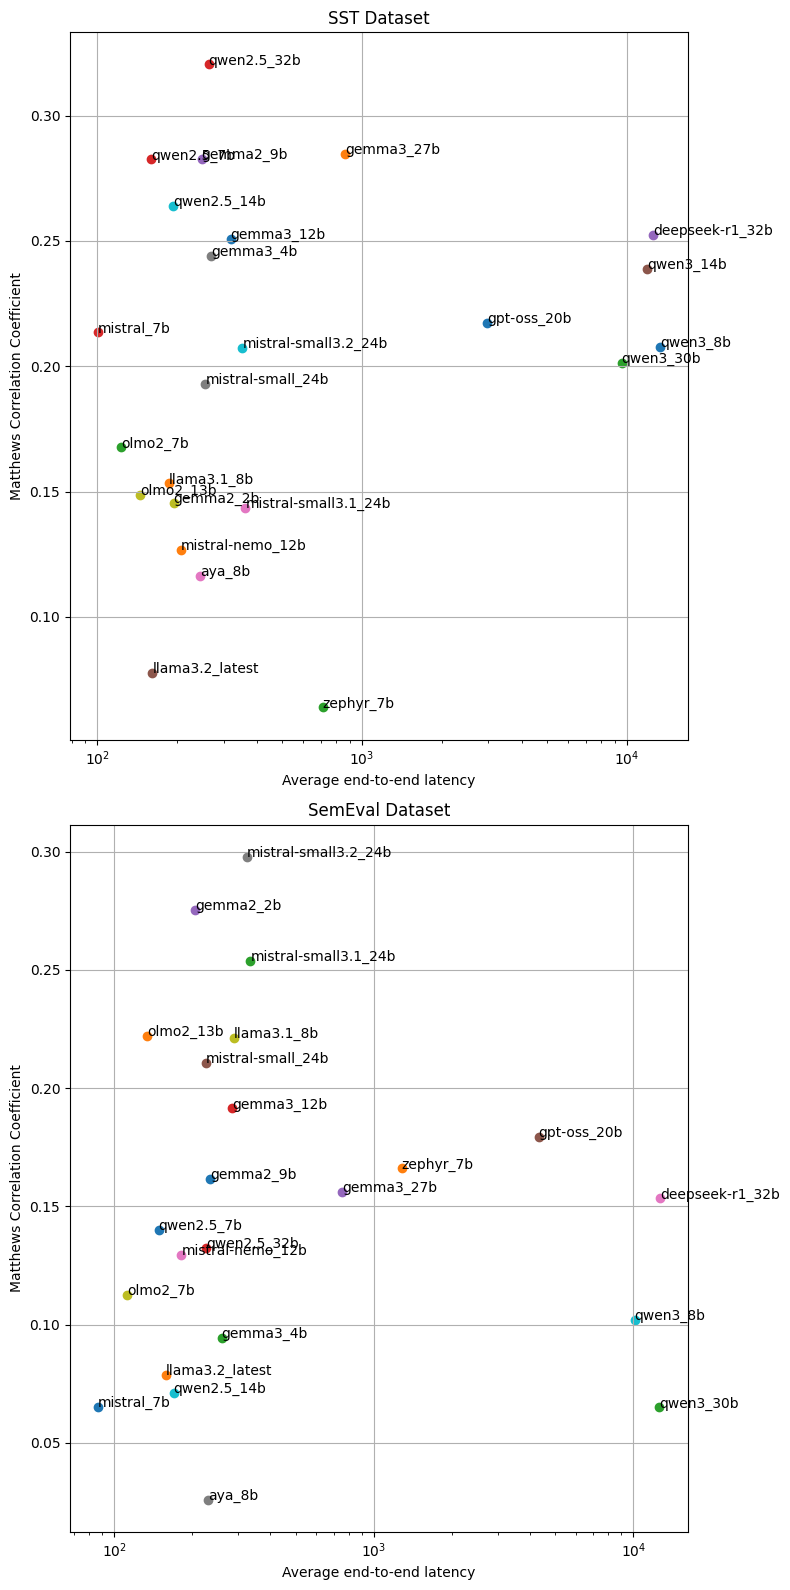

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Average end-to-end latency")
axes[0].set_ylabel("Matthews Correlation Coefficient")
axes[0].set_title("SST Dataset")
axes[0].set_xscale('log')

axes[1].set_xlabel("Average end-to-end latency")
axes[1].set_ylabel("Matthews Correlation Coefficient")
axes[1].set_title("SemEval Dataset")
axes[1].set_xscale('log')

for file in os.listdir():
	if file[-4:] != 'json':
		continue
	if file[:3] == "phi":
		continue
	with open(file, "r") as f:
		performance = json.load(f)
		model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
		if file[-8:] == "sst.json":
			axes[0].scatter(performance["Average end-to-end latency"],
							performance["Matthews Correlation Coefficient"])
			axes[0].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Matthews Correlation Coefficient"]))
		else:  # semeval
			axes[1].scatter(performance["Average end-to-end latency"],
							performance["Matthews Correlation Coefficient"])
			axes[1].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Matthews Correlation Coefficient"]))

plt.tight_layout()
for ax in axes:
	ax.grid(True)
plt.show()

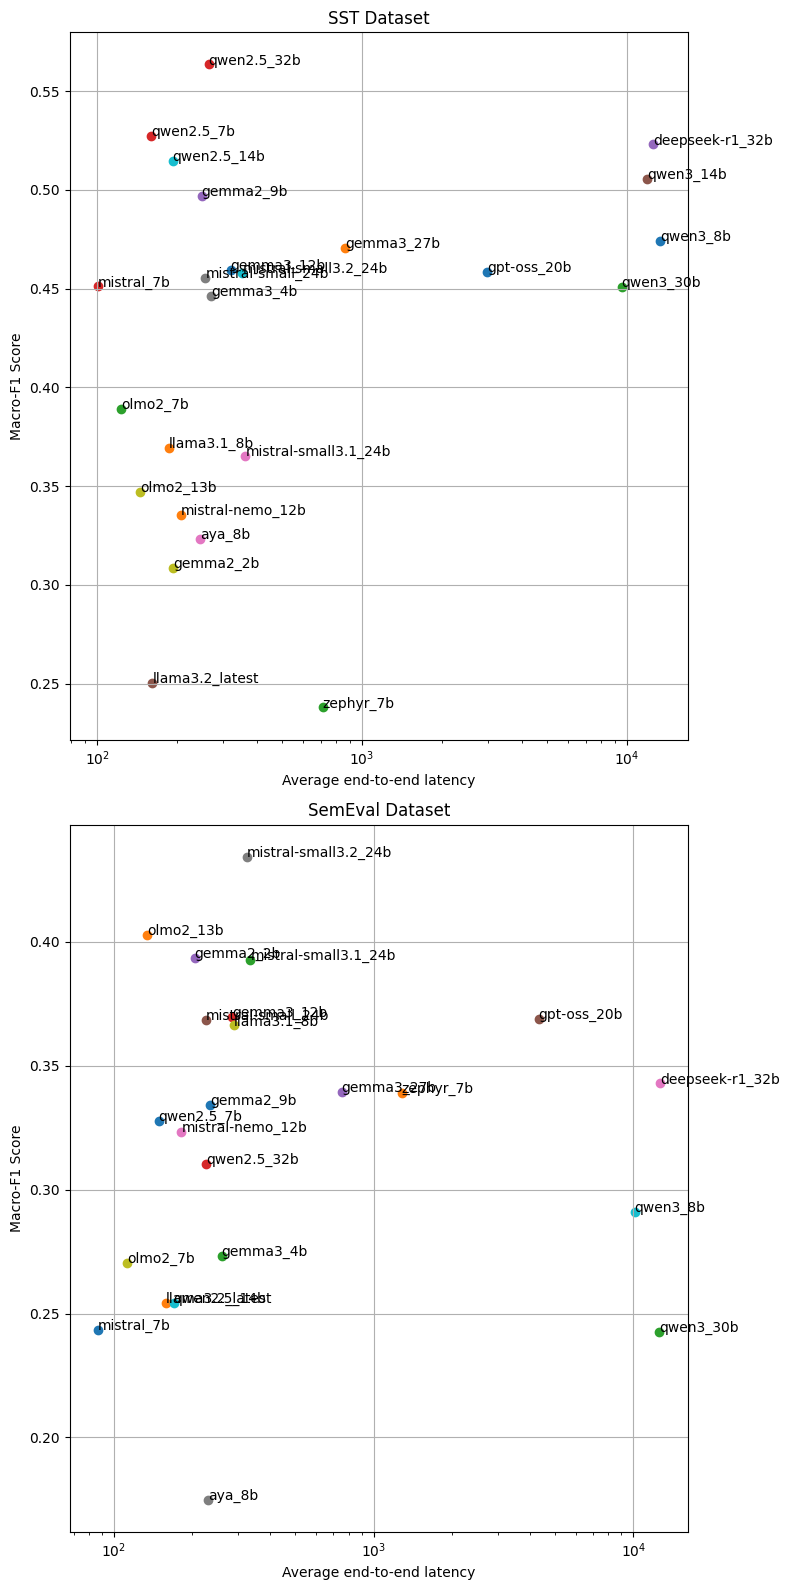

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

axes[0].set_xlabel("Average end-to-end latency")
axes[0].set_ylabel("Macro-F1 Score")
axes[0].set_title("SST Dataset")
axes[0].set_xscale('log')

axes[1].set_xlabel("Average end-to-end latency")
axes[1].set_ylabel("Macro-F1 Score")
axes[1].set_title("SemEval Dataset")
axes[1].set_xscale('log')

for file in os.listdir():
	if file[-4:] != 'json':
		continue
	if file[:3] == "phi":
		continue
	with open(file, "r") as f:
		performance = json.load(f)
		model_name = file[:-9] if file[-8:] == "sst.json" else file[:-13]
		if file[-8:] == "sst.json":
			axes[0].scatter(performance["Average end-to-end latency"],
							performance["Macro-F1 Score"])
			axes[0].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Macro-F1 Score"]))
		else:  # semeval
			axes[1].scatter(performance["Average end-to-end latency"],
							performance["Macro-F1 Score"])
			axes[1].annotate(model_name,
							 (performance["Average end-to-end latency"], performance["Macro-F1 Score"]))

plt.tight_layout()
for ax in axes:
	ax.grid(True)
plt.show()